In [1]:
import os

import matplotlib.pyplot as plt
import torch
import pyro

import torch

from torch.utils.data import DataLoader

import pyro
from pyro.infer import Predictive


from chirho.counterfactual.handlers import MultiWorldCounterfactual
from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.zoning_models.units_causal_model import UnitsCausalModel, RegisterInput
from cities.modeling.svi_inference import run_svi_inference
from cities.utils.data_loader import select_from_data


from cities.utils.data_loader import ZoningDataset
from cities.modeling.evaluation import prep_data_for_test, test_performance

from cities.modeling.simple_linear import SimpleLinear
from cities.modeling.svi_inference import run_svi_inference
from pyro.infer import Predictive
from chirho.robust.handlers.predictive import PredictiveModel
from chirho.interventional.handlers import do



smoke_test = "CI" in os.environ
n = 20 if smoke_test else 2000
num_samples = 10 if smoke_test else 1000
n_steps = 10 if smoke_test else 1000

from cities.utils.data_grabber import find_repo_root

root = find_repo_root()

In [2]:
zoning_data_path = os.path.join(root, "data/minneapolis/processed/zoning_dataset.pt")

zoning_dataset_read = torch.load(zoning_data_path)

zoning_loader = DataLoader(
    zoning_dataset_read, batch_size=len(zoning_dataset_read), shuffle=True
)

data = next(iter(zoning_loader))

print(data['continuous'].keys())
print(data['categorical'].keys())

kwargs = {  
    "categorical": ["year", "month"],
    "continuous": {'limit_con', 'parcel_area'},
    "outcome": "housing_units",
}

subset = select_from_data(data, kwargs)
print(subset.keys())

print(zoning_dataset_read.categorical_levels.keys())

dict_keys(['parcel_area', 'car_parking', 'housing_units', 'limit_con', 'parcel_area_original', 'car_parking_original', 'housing_units_original'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month'])
dict_keys(['outcome', 'categorical', 'continuous'])
dict_keys(['parcel_id', 'neighborhood_id', 'ward_id', 'zone_id', 'limit_id', 'past_reform', 'year', 'month'])


In [6]:
units_model = UnitsCausalModel(**subset, categorical_levels=zoning_dataset_read.categorical_levels)

with pyro.poutine.trace() as tr:
    units_model(**subset)

print(tr.trace.nodes.keys())

tr.trace.nodes['year']['value']

tr.trace.nodes['weights_categorical_year_housing_units']['value']

RuntimeError: einsum(): the number of subscripts in the equation (1) is more than the number of dimensions (0) for operand 1

[iteration 0001] loss: 139793.0312


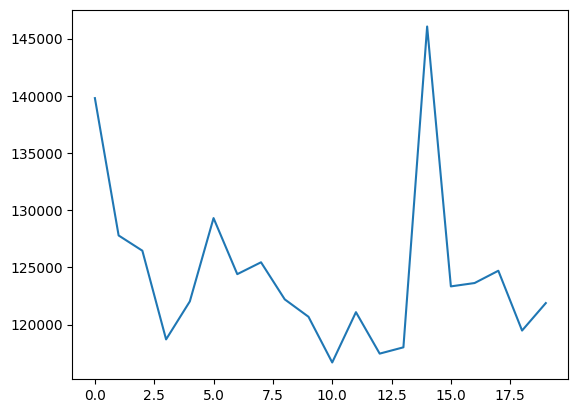

In [4]:

guide = run_svi_inference(units_model, n_steps=20, **subset)

odict_keys(['data', 'parcel_area', 'limit_con', 'year', 'month', 'weights_categorical_year_housing_units', 'weights_categorical_month_housing_units', 'bias_continuous_housing_units', 'weight_continuous_housing_units', 'sigma_housing_units', 'mean_outcome_prediction_housing_units', 'housing_units'])


/home/rafal/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


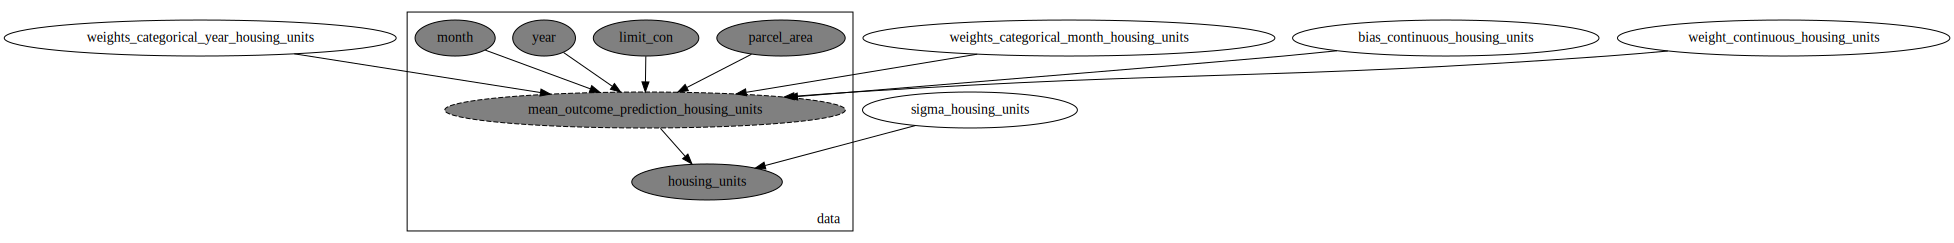

In [5]:
print(tr.trace.nodes.keys())

pyro.render_model(lambda:units_model(**subset),
                   filename="units_causal_model.png",
                     render_deterministic=True)

In [8]:
#n = 302 
#limit_con_exp = torch.tensor(1.).expand((n,) + torch.tensor(1.).shape)
#TODO: why do we need to expand interventions?


with do(actions =  {'limit_con': torch.tensor(1.)}):
    with pyro.poutine.trace() as tr_do:
        units_model(**subset)

print(tr_do.trace.nodes['housing_units']['value'].shape)


RuntimeError: stack expects each tensor to be equal size, but got [] at entry 0 and [302] at entry 1

In [14]:
with MultiWorldCounterfactual() as mwc:
    with do(actions =  {'limit_con': limit_con_exp}):
        with pyro.poutine.trace() as mwc_tr_do:
            units_model(**subset)

#with mwc:
print(mwc_tr_do.trace.nodes['housing_units']['value'].shape)


RuntimeError: stack expects each tensor to be equal size, but got [2, 1, 1, 1, 302] at entry 0 and [302] at entry 1